In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import copy

In [15]:
# Kiểm tra xem có GPU không, nếu không thì dùng CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [16]:
#Khoi tao Model
class Model(nn.Module):
    def __init__(self, backbone='resnet18', n_classes=2): #Khoi tao model(mo hinh dc xay dung san, so output)
        super(Model, self).__init__() #Ke thua phuong thuc va thuoc tinh tu nn.Module
        if backbone == 'resnet18':
            self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            num_ftrs = self.model.fc.in_features
            self.model.fc = nn.Linear(num_ftrs, n_classes)
        elif backbone == 'mobilenet_v2':
            self.model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            num_ftrs = self.model.classifier[1].in_features
            self.model.classifier[1] = nn.Linear(num_ftrs, n_classes)
        else:
            raise ValueError("Unsupported backbone")

    def forward(self, x):
        return self.model(x)

In [17]:
class Learner:
    def __init__(self, model, train_dataloader, val_dataloader, loss, optimizer, scheduler=None, work_dir='./checkpoints', n_epoch=25):
        self.model = model.to(device)
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.work_dir = work_dir
        self.n_epoch = n_epoch
        self.best_model_wts = copy.deepcopy(self.model.state_dict())
        self.best_acc = 0.0

        if not os.path.exists(self.work_dir):
            os.makedirs(self.work_dir)

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in self.train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels % 2

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.loss(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        if self.scheduler:
            self.scheduler.step()

        epoch_loss = running_loss / len(self.train_dataloader.dataset)
        epoch_acc = corrects.double() / len(self.train_dataloader.dataset)
        return epoch_loss, epoch_acc.item()

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in self.val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels % 2
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(self.val_dataloader.dataset)
        epoch_acc = corrects.double() / len(self.val_dataloader.dataset)

        if epoch_acc > self.best_acc:
            self.best_acc = epoch_acc
            self.best_model_wts = copy.deepcopy(self.model.state_dict())
            self.save_checkpoint()

        return epoch_loss, epoch_acc.item()

    def train(self):
        for epoch in range(self.n_epoch):
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc = self.val_epoch()
            print(f"Epoch {epoch+1}/{self.n_epoch} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        self.model.load_state_dict(self.best_model_wts)
        return self.model

    def save_checkpoint(self):
        checkpoint_path = os.path.join(self.work_dir, 'best_model.pth')
        torch.save(self.best_model_wts, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    def load_checkpoint(self, checkpoint_path):
        if os.path.exists(checkpoint_path):
            self.model.load_state_dict(torch.load(checkpoint_path))
            print(f"Checkpoint loaded from {checkpoint_path}")
        else:
            print(f"Checkpoint not found at {checkpoint_path}")

    def test(self, test_dataloader):
        self.model.eval()
        running_loss = 0.0
        corrects = 0

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels % 2
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        loss_mean = running_loss / len(test_dataloader.dataset)
        acc_mean = corrects.double() / len(test_dataloader.dataset)
        return acc_mean.item(), loss_mean

    def inference(self, image_tensor):
        self.model.eval()
        with torch.no_grad():
            image_tensor = image_tensor.to(device).unsqueeze(0)
            output = self.model(image_tensor)
            _, pred = torch.max(output, 1)
        return pred.item()


In [18]:
# Các biến quan trọng
batch_size = 32
num_epochs = 10  # Số epochs

# Chuẩn bị dữ liệu
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = datasets.FakeData(transform=transform)  # Dữ liệu giả lập
val_dataset = datasets.FakeData(transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Khởi tạo mô hình
model = Model(backbone='resnet18', n_classes=2)

# Hàm loss
loss = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler (tuỳ chọn, giúp giảm learning rate theo lịch trình)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [19]:
# Khởi tạo Learner
learner = Learner(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss=loss,
    optimizer=optimizer,
    scheduler=scheduler,
    work_dir="./checkpoints",
    n_epoch=num_epochs
)

# Huấn luyện mô hình
best_model = learner.train()

# Lưu mô hình tốt nhất
torch.save(best_model.state_dict(), "./checkpoints/best_model_final.pth")
print("Best model has been saved successfully!")

Checkpoint saved at ./checkpoints/best_model.pth
Epoch 1/10 - Train Loss: 0.7919, Acc: 0.4990 | Val Loss: 0.7119, Acc: 0.4960
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 2/10 - Train Loss: 0.5893, Acc: 0.6970 | Val Loss: 0.5088, Acc: 0.6980
Epoch 3/10 - Train Loss: 0.3427, Acc: 0.8560 | Val Loss: 0.8670, Acc: 0.6910
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 4/10 - Train Loss: 0.2210, Acc: 0.9140 | Val Loss: 0.4859, Acc: 0.7840
Epoch 5/10 - Train Loss: 0.1426, Acc: 0.9470 | Val Loss: 0.6203, Acc: 0.7410
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 6/10 - Train Loss: 0.0739, Acc: 0.9790 | Val Loss: 0.0550, Acc: 0.9880
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 7/10 - Train Loss: 0.0438, Acc: 0.9880 | Val Loss: 0.0191, Acc: 0.9970
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 8/10 - Train Loss: 0.0230, Acc: 0.9970 | Val Loss: 0.0117, Acc: 0.9980
Checkpoint saved at ./checkpoints/best_model.pth
Epoch 9/10 - Train Loss: 0.0190, Acc: 0.9

In [20]:
print(model)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [21]:
# Khởi tạo lại mô hình với cùng kiến trúc
model = Model(backbone='resnet18', n_classes=2)
model.load_state_dict(torch.load("./checkpoints/best_model_final.pth"))
model.to(device)
model.eval()
print("Model has been loaded successfully!")

Model has been loaded successfully!


<ipython-input-21-91e74b07b792>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./checkpoints/best_model_final.pth"))


<ipython-input-26-272999ec394d>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./checkpoints/best_model_final.pth'))


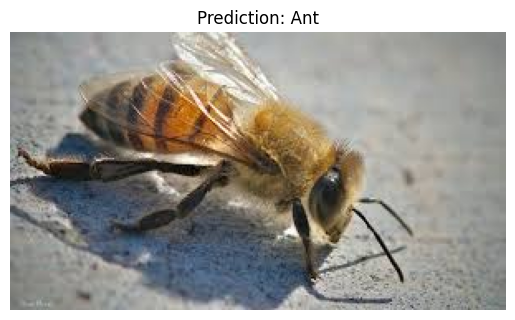

In [26]:
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt


# Chuỗi base64 (rút gọn để minh họa)
image_base64 = "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxITEhUTExMVFhUXGBgYFxcYFxgXFxYXFRUWFxUVFhcYHSggGBolHRcVITEhJSkrLi4uFx8zODMtNygtLisBCgoKDg0OGhAQGy0lHyUtLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLf/AABEIAKgBLAMBIgACEQEDEQH/xAAbAAACAgMBAAAAAAAAAAAAAAADBAIFAAEGB//EADoQAAEDAgQEAwYFBAICAwAAAAEAAhEDIQQSMUEFUWFxBiKBEzKRobHwQsHR4fEUI1JiB4IzshVyov/EABkBAAMBAQEAAAAAAAAAAAAAAAABAgMEBf/EACQRAAICAwACAgMAAwAAAAAAAAABAhEDEiExQRNRImHwQnHR/9oADAMBAAIRAxEAPwCVOkjCisB6It4shkmjTMKVIkI1By25iLAk0IrEKnKYYOaY0heq0ymKSJiGgiyFhxGqQ2Hcsa1Ti1lumkIisW6q0H2QMd4e8thwHfrtE6KwrV80tdLTu21rX6qt4LjgXmiYh+x0JVxXwDgLeaI8v4xYTkduNLEHRS0MqsRQZPkMOG99RqD1k/JN0eJOLcjhFQe64GNP2lIvxQefMehPuu53OhW6tDK2HnNTNmvaAcu5BBvOnbqs7aLpMcqYb28VMwloObKL9JG6qWvB/fVXPBmhs+zuW3Bmc8/hdzE7oPGaDc3tGNIOj2TEHnCpSolq+FY5Y1qO1oN1LItjMWc1Y1qM9qiAkMGQokopaoFqXkDGlactwoylQzCEF5TOZL1QgZDNKgSiMapOpoEAJQnMRy1ac1ACzghuTLmoLmosKAuCGQmcig5qYhclRRHtUCEwDgjdFphCYAUailYUbaALo1OCENzZUqREJoCTWkFGeUJlWUR1ZogHUpt0JEqJG6K6mHXCTEkzAhHoO2mPWFDyIpQYVrSFNreoSNbilBhguBPIXRX8TYGh5hrbSe+6h5S1jHW3sSiuwvlcQ2XNNweW0DdczX41VNU0xTAIJB3Ijrp6hXWAx7hEkZhJYTG2rXf6/wAb2zlnSdMtYWU54iG1Ie1reRiJ9d+66jhniEmAXSDoTPe5lVPFhSrj2opzBiq2PM071GydrE2AcIvbypYHh0f45eYLr9YP6W7hTObi7svS1R2WLwrKsukUzqXSMrtecd1T16WQwHsNtWOkeoRcDxr2QDDMSIOpG0dQugwWJw1VujCeR19JuqhkjMzcJR9HKUKrmOBERN9RHMiND2XStcKzYABqN3BH9xvIkb7greM4KwzkH/Sb92E/QqpZSq0f7lIy0G/Lq17fwnaVVa+BXZEYVxkt2mQdQRMg9TCgx8q1w1RtZ5qtABAh9Mm7na3/ANhFj+KToVDiuChwqMBDHaiPcduDyGiuL4TLyV5ZKhlTTdEOoxXZIF5QfaI7qSAaBBSA0VEsRcllJgQFi8FZlTDmrC1MLEyIUw5Sc1Rc1FCsG4oLnJnIgvpoGQF1BzUYBYQpGAQ3hMFqE8JiYs8KBajvQymI20BEpwhEiLqPsJuHWTaAcFLqp4egEP2c7omGw7h+JSMMyiJhAxeFiT1E+uh+RH/XsjDDuLhBSPiTiYoMLibwR3B1Eb8+4B2Sn1Dh5AV+KNp21Ko+LcZfEAxPpAVfTxftDPvNO8/Od/VJcTYc1rjluFnGKZo3RbcNiZc4CRIMTJ5ff8Lcax01IzeRoAgaX1IHRCw9fK2IkRF/j6fsq8UC+KjTMQ1wm7P8Z/1OgPccpah22Pb0jreHYhxa0vddoDWuH+LRDZjUDToh8d4i9gg+UuOovIBkxz2H3bWG8rI6RzjpfTVc9xLHO9o5tnNFoNwYEEmfW+q4ox+TL/o7X+GO/s6nw7xMl7RmAdOXMfdIBsyoDq22uo6iy7HBV2PcaDpbmk0yYgON2iQIykSJFuWq894TTYGhwaZJAy6guMAActdL+uium1nUwGuuAbQb0zzpu/DcdumhHNlz6ZK9GsMG0b9l3Tqtz5HNLXh4DgQDcOFpG287iFDi2KFPystUN7bCde+np6JviWIbXof1bRmqUQBVYAQ7KLh5A1baZ5SL5VX5W4il/VMzFpALmGS6iT/7MM2d6GFXV1dXr+/XszcV/wBL7gnFaLPI6WB0EOa52UOd7wdBsbG5myuKuHfIfRcCSPNmvmH/AF97WJXn2Ex5D/Z+8HRb/IAmWn6/wunwjHsHkc4N1yzod+nquvDlbXTly49XwYqsIqB7WmnUGw06Rz7d4Vlhsf7T3jBMCDds6AEbtN/uyUfjnEecB3WIMm0mLH4KoxuLE2OmgnqbD4hOeeMHxkxxuSLWoMrnNIykG7dY9dx1WKrGPLvM4yRqefJMU8QI+/gtceeEiJ4mhpwQgAs9rZCbVuuhGRN4Q8qk9wUMyaEyQC05qiHqQrhSxog5iFlTTngoZQgF3mEEuRqqEQnYECtFTKg5AiGZCetmpCwuCQ2BKG4IxKgUCMLW6/FEwzQTAiBslgNHXEcuXUKVBozRoYkHT+UwGXS0k2PII+Ac5w81ilKbA6QZ6R+qZoMyibx1SGWLWQbLzP8A5Dw9ZteX3pn3TtfYroa3iihSqlsvMaxceiDxTjmGxTC0zc7i47IaY014OC4Q4tcYMK2q4hpdDvK7mND+iT4vwapQPtGS6md+XQpPE4omHR0P5JV7C64XdSmchymbfcIHBHmm8nSxBm4IMS1w5foCLgFL4DEB4cLggE23gct9kTA44lwAgnkbel/2USdJo2graZ0znNLS4aAaEzFrQRqOR+i5fB0g6peddSNzzVticQGtMtcwkRmyyDOxIkEeqruGVWSbi8W09LrlgtYyaO2T2lFM6LD0ssGdARYRqbnWCnQA4ZpsJJOojkdwddearqVRsgEt7E39N1mMxTGsiXAnSxB7D5LyXilOdNHc5KMRfA8fqtxQdS2GUt1a5hs5pE6HlttddvwyuBNbCWyj+7QN/Zt/2A9+kbw4CwFwCDHB8LYcxc5lzYZYBjqDAJ7K+4YageH0SW1aYzAxo3QyPxNNpiQuuVRkorwv6zmraNvyXGKwlB1anWoZmPDg99H3gwC5cxw1YRcRMxFl1GLAEFo97r8QOdwFS8E4hReS9rAyo0ONTDi7STANTDE3AO7flaUg/iwBLcx9mTNJ0SGDem5pPlI+Bi0rfalw5pxtkuOcRLYaDZ0ye2g+fyQMPiG5Da8d/lzVTxgOeWkDMCfKQQQbiI0M9EH2mRrZcCXXIgiIvrNtZ+C4pQcpbG6aUaLsuvZxgaafZTtKr6Hkf1VLh8QNR8eQ68lYYPEgnz9wZtfY/qqgm3ZnKqLRmK5/fdNUS12ir8RSjncXiLEaxt+6hhCQbD5z9F34c7T1ZzZMaatFoaUFReje0kXUMi7kcrIsaouoBHbThYShsEhYNhDdWAKYc5L16F5SGBqElSFOymwhFeEIGKFiiQjEoTymIWfSuh1GwEzKHUTEKAqSLkCiUAJY2tGQkRJiRNiPwkiw7nSEWqXkSHeYEEA2Dgdib/FB4ngmVixr3GmwEv2BLgCBJOggzGtlT8K4v/Sufh8S4lrCCxwaRa18rgbXm0iR1UylXkqMbXPJ1dOqMs1BkIib2uqfxHx8CllpmXH81ZcWqU6tIsY+D5ZMiANjyiLrl6mEw8+bE0tBqT5TMEEgEW6EpxyQvoPHKuHM1CTeFAVr2kHmuifSwk/+en6uy26A/H06qvx7KAENqU3H/V4dcHodxz5LdZoS4ZPDOJKhxh2TI4kjlsljSpvkARKcweFoBodXrspnXK5rnZ2/6BoMGx1jUQlquNwg9ypV0tNLvAnNpprMfJYyq+GsU66Qw3BarHZmie10tisC+m7Qt3bY6q44b4opU9HTykOn6eit6PjXCi9Rmc8i2O0BwjXpe6ydmkXRX4PG5mZSdRcHsqcUyHDMJbMEaCOdl2L/AB3w1zMv9I1p/wA2gE31IbA+v7BbjuFuI/uNveSS2OjuR6LBYtbo6PmvyUwwDBJYXMPQ/uJ9ULEsqiDmD45gSRadF6NwPhfD6gkOpkbQ8EfJy6Z3hTBvADS1sX8sX+KiOKS9lSzx+jyLBcXZdtakW5rEgTuDab6xMbCN133BqWEe3NSqNPNoMOaY1AnM2ZKbxfgSi6wvfXTTbvP0XPcW8K0qNMvfLALh4gEW0AB7fqsp4UUstm+NcPY0FzbmZz3Dmno0bW2jtuuPx+NeXFxMn8R1mTJM/iBO/wCaynxhxJFKsaguMtQHYkazbnqk8Zij+Jhaeolp9R9Vag4+RbpjXD+JZAQTLQcwB5yPuVYVaZLiS3OASQWXBzEQQ4aQdtdFy1bzGafva5Z+id4Pxo03ODy803A5qbSNdA5s79N4CcsH+USFk7TLmjiABEAAaF0DSZJJvqfon6WILR5ifhA/17xrN9lTcSxDWOL6JlroyuPzsdDpIUsLxBrgG1dB+ITI6kHWbLJwtWUpdOx4djPwiDDZdGgje+h3VrhWgyfhzncX+9VyvDHFvm2J+V5t8VY4vizRUdkm9wNri5F5Kxk68F1Y/iuIta8tmzR8TIAj1Le4JTHDcSHXkaTrPPU7AQe5B9eB4zVu2+aXXvFucpqniyGBjSco66m2p30H3EduHM9E2YZMSbpHoL51BlTYZC5zw7jXudlJ178gPv0XQPbG66k9lZzta8B1KV1GVN5IQzdUSR9mJlbeVvIUvULpSGSfTUX00WTCXeSixNA4Q3tKk0ElaqkqrFQJzShEFFzITigCNOg+zjlBJGZxgSAOcaAet9UTH8LpVabjXbTdkBaXF2XIDpDwfLsubPD8RWIFSu4OEkAA+WdTbLmuRcdbqs4pwp1Jxl5Oa5kmdJBI72vfRU42Cf0E43wb+lIqYbFtrGTnpuewVGg2NpGcHQxcR8OHe5wMGRFr8hYD8lc4iiJi88pQP6Ian57fJNYF6B5mV3tDzUSJ1Vi3CNOn7rZwbREib8z+SfxtE/JYN9Uki5mddbEAAD4D4lOPeALkI1PB04Hl7fZW6fDqe8nudvRTo0VsVz6s766ZR+aLR4ZXf7tOOrz+quKdNrR5WwecfU6qVOuc13kHtb5JUxjXAP8Aj51dwz12NnZon5kjpsgcZ8AVqNUsa4RJA9p5SeRETMpnB8WqUniHE8oFtdZXpFXFnE4allLSNZM2MattfeQodlKjxvFeBsYBmDG1B/q4T1s6NlT1eEYhhvSqNMi4YRvqDEcvgvY61KtSg1ABIsRo4cwtYHFF2YuIaBvsI5nRS5NFao894bQxkS+pWadYzvaCBpIm4sfuExi8c8MyF5IBkAucQCbTcm/zT3iTxEwlzaZlosXRGcyPK06x/tdUlHgtWuzPBh0kXgRPzU17Y7rwb4dSbqCy03ac35WP3dXuG/uNhwmLXFj1hD4F4ffTBL4BOw/PZGxtBzdFnk6VHhTYvhMOzMm2v6BLVcG4CSy5jSJ53AVtTxUC9zHzUBL5kxdJTkgpMW4e1wY5ht+Ng6/iEdR9E7h6BLrHrBNo+KjXptDfKZP86LWFxQaTINtCNSI3nTupfelLnC5e14p+WTIO0CBcalJ0Kns4LpLjowanUmI26xunG12Cm57sxaG31DZvo0WcdBPMeq4nEYx5eah1+nIBRiwfI3fgqeXRfs6TifDMQya7agc1o841GsRI0MiInZE4Sc/y+f8AO65/Gccq1KTaTjIbmLbAOh0ZmuIu4d9Nl1ngekXssbmxHbmt88VFL9GeKTbZ0vAsPEEajX0V1WJlQ4Xhck+qk8TZVgX4kZX+RntAlMfULBmCbZREIWKoZmkLZszQtw/He0ajFyR4bw/2cyVZBoCkoVbWMwtvciuaEGqxUkS2Ra5CqVEQNQqjZTFYMlBKYgIRhFCIVmAVGlzZI91wFxzn0UOIYJtUXab7gXB0k8/RUVHGV8O4h8kHcyR6HZdFwzilOsLAyLRuPncKmmNNHK4ngL23aM14vYz239LKorUXNcWvaWmJGolel18Q1ouSGiJsLCTqTtED0SviGjTrMacpBE+YaQTIkHXv1Vwm15JlFNHnfsTItp6Ryj73Wq+GdPIfelk+/Dua4ixETmBsQTFhrMg2hC9mQd4mbbT0F9F0J2jBqmJYfDuAuZ7R3TDeQ1TXs5Onb72/dDqZRtHaT/CKHbMkfxt3Whl5zGp203WGwzajUdtVOjRDoM37z30Wcoo0jJm/LHmg9IVlgsc5jRBIaNG7d4OqqcViKVP3iDH4Rczz6fskhx0j3KY7k/kFzuvRqj0M8fa6m72zw9obo6PKBBzCLArgvEHiH2xy0xkpjYR5urrSe0kfVLYjiRqsLSIIM2Jv3BSuCwOa50369ApSV9Hf0N8CwmaoKjxLGEG+hcNPhquuZjRaLt0gC0dByVHT8tgCG7N0kcj+qm2o6QYyxtJhOUbEnR2XCqLqpOQEga9OVk1iuES0HKRzzCPT81yeF409tmwLz5TEjlEq4p+Iaxc2XyIi4mDGt1m4FqQnjuBA2uHaRFuen3uq4cLeN7An5a99fmuj/wDk9zBJsek/Tujio10wOU6DTQffILKUaLTOAx2Ia12TN1nUDqYStOv57BxBEkiAY3MakdLaLpq3hxz3HK0BpOttNhp81z3jPDGhWY2dKbTa2rnz81UEpOhSbSsvPElIUqNOm0zmcJMATAtPPb4LkOIstA2P5Lo8FVOIwTHTLqDsrueWPKT6EfBUOJtVeDuZTx/jwmfeiGFZLgF6n4CwBALogE+t46Lh+EcNL3WC9Dcx2WlSovDJM5iC4Zvw2BEkENtImT6Z53twvGqLjj/HPYQPYVnzu1hI9TCTw3iGm5uYsrNtJzUyGt6Zt/gt8O8SVPbnCYtgp4kCWOB/t4honzUib7E5dr8levXRGLUaMZO3YnhcUyrTFSm4Oabgj8+Sm6SFzvEuGVMPUOJwu5mrR/C/m5vJ31VpgeKMrUw9k31G7TuCFQg7xzWmulRrUrW1Q2sIUtFJmq5M2Uc53RYQDrCaEyJCGZUyDCCwmbqiQbyQo+0TD2pd1IoADiarbhxdB5CUpV4UPfpPyOt2PLsrIUgQjNogi4Fvn/CNh0VFfiFen78AQATAII5ym8FxypILnsLIu0wOxBTjqId7wBj6ciqvifAQcxptlhH/AI+XUIAY8T4enVotfQyhw1Fp16a91yrXObYkA8jAnqF0nDKbGsDdC0aHfpdVnEuHgn2hadesC+4VY506YpKxVzQb2mD3SOMxUQBczEQIPKUxULtI7QEqaDjfLcaHRdD6jJKmKu4q0Hz04MQOUHodkPF8aBaQzymNkxicAXXN0seEaKNJNUPeKZUtBdoCfiVYYfh1V94De/LsFYUMOWiPj9U5kBvP5dt1DxyLU0AoYNrGkBs6STeT98kHFVw0W1BEC1ptEJgVxMaX/nVBxNH2hBcbje0dT1SURtkmVybEQfl2WmVpJAF//tb7ut06I15dbGd0TJAn7PNaURZjLWg+hn6rbXnbMChigdZ3Ej1t9FlSkdZIG9zPZS4DUhyhiSZa6RGjgZnvZXeCxbCwSXSNAAAAY16rng4gEghveD9LkptlOsLggz2Gsa69tN1jKBakdXheIyWtAmTEAT2sFS/8s8Aqso0MQWke8x4OoJOZk/8A7+IV1w7iVOg+m5hd7YNIcbFoMH8Nifw78+SPj/EL8Xh6mHxPsnNc2zx5XBwMh2TmDB9Fmko9L2vhxH/E9QOr1cO/3arAQNszCfycfgE94u8LGlUztu2YnkdpVd4HcyjjtYIzMuPL7w8xO2i9U4oKdak6m4tIdaoJLSA4HzNOx0usst7Wi4eKZ5bhcS2mQwG51Owjbuu08M4Nz3ms6zW2Z1MRJ+J+S4ytwlxxH9O1lSHOEEgyRM5i8C7QNx9V6hg6ZptFMBuVtgRIM9Qde6UI27HKVCviXg4xVINLoqMOejVA81Kq27XjpIEjcehCXhrjRxFMtqN9niacCtTNsriPeaP8Xaj4KwxNTEAGA038sA6ciuc8XUa9NtPGUG/3qIPtANKtI++0jfLEjl5l1GJ1BdbW65zilJ1Cr7ei0mf/ACsGjx/kP9grHAY0VKLK1EZqb7zuJ1HcGyfqNloIbYodCSAYfHNq02vYZB+S3WeYS2DwraJeWgw45svI7winE9PRTbKo3RNlE9lr+pA/ChtxIIJA0TTE0RfU2GqHJIUBXGbTVbe7fRV4JNPJQ3PKj7b1QX4iDoUATo1jMEIlFxlL4atIvqi576IAabUAU2YkBwsYO6AHdNVKs6wiLIDgXEcPp1AZHmmZGsKtfwyobMq6yIKsRWMC4B3WsK10umOYKE6GcvicI+mPOx1vxC4VcKxJsDJ2XeYTHB7zTc3ygb9VXV/C9MuzU3lvQ7FarL6ZLxnKYms5oEsdPLdP4SiHQAPTun+I8KrNgRnHNu3dBFd1Agimc1ve0jdaLJzhDx/ZvH8ENMB5bANv1MclS1RMiCBBHXorbH8bqPIsMsaawZSL3lzTICtN0Q6sTp0LAA3jQiPmPRS9m4G5gbERMDlOyYpkZQc3xRQAGgyOnUzoqSE2KucbDf4j1/hbzaz31H36IlSoNP1/JaLDLYI5we14KGJA3VRp0nSPSQtBwN4I56H4ojjA2E2j0WZgQeiVDsG2Z94GTbpF47/sjPrRoQ0giCLwTGvJL0nNAzEEdO+3JSzAnv8Af5KJRspSokMW6/mBi3TlHdQFYzJdFuh+g+4QatSCAGWFp5actoWnYjoI+fpCyljLUwLWxiMw3Av1Gp/9U5jMXVdLcxA0gHWdolVtbEgVWRvb6jf7su18L8GDia1V3sqTZhzspBdFhDrGCeXJYKPemzfC68H8NqsoNdWqnm1hc2Gt08wIsZm0j8l0dV4dduV3IjpqqU+J6IJAzVCZzOps99wgSIMOtG+iXOMxDzNKgKTBJc6oWgEmIdlFxptKEiWXlXGMAMuaCJkExED5KvHGaADg5wa4GwHmzTyyyqmv4aNQsfiKhqEukCcrANiI975aq8w+FpU4DGtaALmANdDOyAOI4LxB2DxD8Oym8YfEOLsO18sDals9ME2i9vRdSMPiXEGo4Mbsxl/i4rfivhLcVhzSLgyoCHUnkxlqtu0jvoY2KV8J8cdiqRbUGWvSOSs2bhwsHesH1BRY2i4qOIMdNUs6oLA69kaqzvCE5s7kd9+yKCzHuvASwbeYPXkpVgddT3+ZWhWH+WoQwA1XzJjRCFSWyUWo2Ii4KA61h8CmIyIEgILpRGDrZSLwqEJU7HRHpndDp1FOmCpGFFRMBocOSA1ynTcYugLCU2tBghEmAQ26C5xASNPjTGkh1igZaUmHVFc10oNKtmuNCpvxBaYiUUKx2g4AXOv1QuJOYW+YAlbqObaddlr2EyXQmkFnHY/DNBnZJ5YFl1mJ4G1xkWVdi+CGCII6reOT0ZOBz1KiS3zHU2RRS53FrckSrhXMFhMKNJ+caQVopEuLGC2RBQalMaXELVpvK224mZvZXsRqaFLcGeh/JQp040mOQt/KMMM4+YggfJad6+qVodWArMAB/Plul6rJMgAiPQjp97p1zA4SLHb059EHMBDXe/G31TsmhWrTvY2A0m5JQauHE63v9jldOmlNxmnaN113hrws1zfaVrcm8yD+KFE5alxjZ5xTwWeqGZmsJPldUcWsB18zoMaRpuNNV6TwLg0U2+3ph7vKc+Yuyubd1MgeU6RmGYH4yr4n8MNbUbVoMzNBBLBDssc2zdpA5K94VxylXphgLQ8DL7MyIDbWgea146barmkreyOiPFTHMO0N91rGOmC4ADNFyYAaNeS1iKYLHZjzvOTLe8uG306rKtMkmXGIgiA4fD9kI1mCW57gyfW/7c1FDNm2waIHm0BdpHwGpvySlfEVA+zfaUzEQDmHMGQRbWbTI0gph5BEt8pBIBczMPNy3jf6rG0cty4OI/yGkf4Fo1I+zqlQEKpc7aGciCCCDrLT9wqGvQNLiVKvSafZ16bqdWBbNTbLCYtNgP8AquiDBOe0kchYWkaZosLd9FA1REn0iZNzt97ophYN7TnJvGszYdI56fNRmXbm/MQI5g6oxeZ1B3AvpffRLUYub5SZE6TuRN7QNhun0XAZGVx1ymSYgBsbdUMU2u2jbaD8EUEtIzOzTMQDEWjN1WVabXCCMtzobyNCgBUAZS0EiNo03UXjNB/YouUC0kiNfxH4IVK25J0vrdCYmDe4ARpdAqVGzoUepOpgjZByEaJgRoGDfRNsy3hx6CPzWLEAFqZCRBIHad9fh9EKpTvY2WLEmCC5psl6/Dab9QFpYiirofojK2Bsi4d2pcsWJolm2uDvyRqIO6xYqkqBBiRojOIsD2WLFAwTuGMJ2Vc3gDDmG+y0sQpNDqwLvC06GFY4fw7TDNJWLFe7JpCtfhRgtb7v4RPxVTieB1abZN/yWLFUJOxSSK1tLLIiDyQq+Dz3iT0H0WLFpsxaov8Aw14eMipVaS3TKRfve66j2rwxwDbgwAd40v2WLFhKTky6SI03xd3Qfmq7EcHw1R5fkyu1JaSJPMRusWJeA8iWJ4I2ZbWxDRvDswjQa3gWQcR4ec+YxNYbQSQY5SHCR8isWITYMgzgNceYYt9iROUyASM0jN/qL8gFN/C8TMjGP31bH5zstrE7dhRqhwauCC/E1HgEGLtDocBBJzAjpv01T4BBBBAaQWxO02gRBM6C/pdYsRdiAA+Y+UhwiJJa12vum+lpHa0Qp1ruidREaHvIEgwfksWIYGVBoB666DfX9UvTeHAugidib2MWAkDQfFYsSAgXgEHNfSIiTew6WNuyg9ozOcJ5EfORNoWLEewBVA7ofX7uh67H5LFiYkj/2Q=="

# Tách phần dữ liệu base64
base64_data = image_base64.split(",")[1]
image_data = base64.b64decode(base64_data)
image = Image.open(BytesIO(image_data)).convert("RGB")

# Hàm dự đoán nhãn của hình ảnh
def predict_image(model, image, transform, class_names):
    model.eval()
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return class_names[preds[0]]

# Hàm hiển thị hình ảnh cùng với dự đoán
def show_image_with_prediction(image, prediction):
    plt.imshow(image)
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()


image = Image.open(BytesIO(image_data)).convert("RGB")  # Đã có sẵn trong code


# Định nghĩa các phép biến đổi cho hình ảnh
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Danh sách tên các lớp (cập nhật theo mô hình của bạn)
class_names = ['Ant', 'Bee']

# Tải mô hình đã huấn luyện
model = Model(backbone='resnet18', n_classes=len(class_names))
model.load_state_dict(torch.load('./checkpoints/best_model_final.pth'))
model = model.to(device)

# Dự đoán nhãn của hình ảnh
prediction = predict_image(model, image, transform, class_names)

# Hiển thị hình ảnh cùng với dự đoán
show_image_with_prediction(image, prediction)